W-Transpose: 
[[ -7.20125254  -9.39774111 -40.76828046 -22.27131471  -1.39612021
   -0.07949534  -0.57597358   2.57257487  -0.88365783  -0.57378709
    0.94794039   1.02350076   1.15928768  15.14510775   0.56698664
    0.61841326  -0.65248677  -1.63780041   0.35031211   0.86457869
   -7.24303551 -10.6685942  -37.82779087  25.3033674   -0.49944477
    0.44909233  -0.31998098   0.16809066  -1.36718912   1.88889288]]

Bias: 1.2473588982111485


ACCURACY CALCULATED ON TEST DATA: 0.9302325581395349
PRECISION CALCULATED ON TEST DATA: 0.96875
RECALL CALCULATED ON TEST DATA: 0.8611111111111112




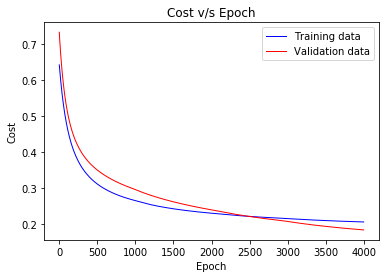

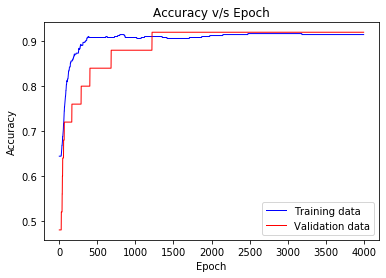

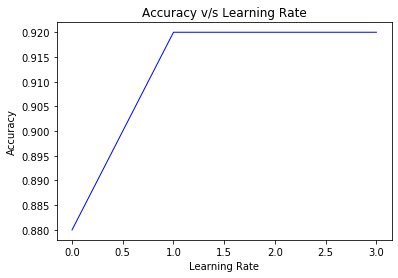

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

'''
Preprocessing the data
'''
# read data from file
data = pd.read_csv("data/wdbc.csv", header=None)

# Manipulate label to reflect 0/1 for B/M
data[1] = data[1].apply({'B': 0, 'M': 1}.get)

# drop the id column
to_drop = [0]
data.drop(to_drop, inplace=True, axis=1)

# Manipulate data to get i/p (X) and o/p (Y)
Y = np.array([data[1]])
Y = Y.transpose()
to_drop = [1]
data.drop(to_drop, inplace=True, axis=1)
X = data.to_numpy()

# split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

# splitting training set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.05, random_state=1)

# normalize the data
scaler = Normalizer().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

'''
Implementing Logistic Regression
'''
epochs = 1000
learning_rate = [0.5, 0.6, 0.7, 1]
W = np.random.randn(X_train.shape[1], 1) * 0.89
# W = np.zeros((X_train.shape[1],1))
bias = 0.02
batch_size = 46
X_train_batches = []
Y_train_batches = []
losstrack_val = []
losstrack_train = []
accuracy_list_val = []
accuracy_list_train = []
accuracy_list_for_learning_rate = []

# sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# function to generate confusion matrix
def gen_confusion_matrix(Y_actual, Y_predicted):
    confusion_matrix = {}
    confusion_matrix['TP'] = confusion_matrix['TN'] = confusion_matrix['FP'] = confusion_matrix['FN'] = 0
    for i in range(0, len(Y_actual)):
        if Y_predicted[i][0] == Y_actual[i][0] and Y_predicted[i][0] == 1:
            confusion_matrix['TP'] = int(confusion_matrix['TP']) + 1
        elif Y_predicted[i][0] == Y_actual[i][0] and Y_predicted[i][0] == 0:
            confusion_matrix['TN'] = int(confusion_matrix['TN']) + 1
        elif Y_predicted[i][0] != Y_actual[i][0] and Y_predicted[i][0] == 1:
            confusion_matrix['FP'] = int(confusion_matrix['FP']) + 1
        elif Y_predicted[i][0] != Y_actual[i][0] and Y_predicted[i][0] == 0:
            confusion_matrix['FN'] = int(confusion_matrix['FN']) + 1
    return confusion_matrix

# splitting training data set into batches
for i in range(0, len(X_train), batch_size):
    X_train_batches.append(X_train[i:i + batch_size])
    Y_train_batches.append(Y_train[i:i + batch_size])

'''
Implementing Gradient Descent to predict a probable W and bias
'''
for lr in learning_rate:
    for epoch in range(epochs):
        for i in range(0, len(X_train_batches)):
            m = X_train_batches[i].shape[0]
            z = np.dot(X_train_batches[i], W) + bias
            p = sigmoid(z)
            dz = np.subtract(p, Y_train_batches[i])
            dw = (1 / m) * np.dot(dz.transpose(), X_train_batches[i])
            dw = dw.transpose()
            db = (1 / m) * np.sum(dz.transpose())
            W = W - lr * dw
            bias = bias - lr * db

        # calculating the cost for training set data
        m_train = X_train.shape[0]
        z_train = np.dot(X_train, W) + bias
        p_train = sigmoid(z_train)
        train_cost = -np.sum(
            np.multiply(np.log(p_train), Y_train) + np.multiply((1 - Y_train), np.log(1 - p_train))) / m_train
        losstrack_train.append(np.squeeze(train_cost))
        
        # Calculating accuracy for training data set
        pred_Y_train = []
        for i in range(0, len(p_train)):
            if p_train[i] >= 0.5:
                pred_Y_train.append([1])
            else:
                pred_Y_train.append([0])

        pred_Y_train = np.array(pred_Y_train)
        conf_matrix_train_epoch = gen_confusion_matrix(Y_train, pred_Y_train)
        accuracy_train = (conf_matrix_train_epoch['TP'] + conf_matrix_train_epoch['TN']) / (
                    conf_matrix_train_epoch['TP'] + conf_matrix_train_epoch['TN'] + 
                    conf_matrix_train_epoch['FP'] + conf_matrix_train_epoch['FN'])
        accuracy_list_train.append(np.squeeze(accuracy_train))

        # calculating the cost for validation set data
        m_val = len(X_val)
        z_val = np.dot(X_val, W) + bias
        p_val = sigmoid(z_val)
        validation_cost = -np.sum(
            np.multiply(np.log(p_val), Y_val) + np.multiply((1 - Y_val), np.log(1 - p_val))) / m_val
        losstrack_val.append(np.squeeze(validation_cost))

        # Calculating accuracy for validation data set
        pred_Y_val = []
        for i in range(0, len(p_val)):
            if p_val[i] >= 0.5:
                pred_Y_val.append([1])
            else:
                pred_Y_val.append([0])

        pred_Y_val = np.array(pred_Y_val)
        conf_matrix_val_epoch = gen_confusion_matrix(Y_val, pred_Y_val)
        accuracy_val = (conf_matrix_val_epoch['TP'] + conf_matrix_val_epoch['TN']) / (
                    conf_matrix_val_epoch['TP'] + conf_matrix_val_epoch['TN'] + 
                    conf_matrix_val_epoch['FP'] + conf_matrix_val_epoch['FN'])
        accuracy_list_val.append(np.squeeze(accuracy_val))

    accuracy_list_for_learning_rate.append(np.squeeze(accuracy_val))

'''
Calculating Accuracy, Recall and Precision on Test data with the finalized W and bias
'''
WT = W.transpose()
print("W-Transpose: \n" + str(WT) + "\n")
print("Bias: " + str(bias))
print("\n")
m_test = len(X_test)
z_test = np.dot(X_test, W) + bias
p_test = sigmoid(z_test)
test_cost = -np.sum(np.multiply(np.log(p_test), Y_test) + np.multiply((1 - Y_test), np.log(1 - p_test))) / m_test
pred_Y_test = []
for i in range(0, len(p_test)):
    if p_test[i] >= 0.5:
        pred_Y_test.append([1])
    else:
        pred_Y_test.append([0])
final_conf_matrix_test = gen_confusion_matrix(Y_test, pred_Y_test)

accuracy_final = (final_conf_matrix_test['TP'] + final_conf_matrix_test['TN']) / (
                final_conf_matrix_test['TP'] + final_conf_matrix_test['TN'] + 
                final_conf_matrix_test['FP'] + final_conf_matrix_test['FN'])
precision_final = final_conf_matrix_test['TP'] / (final_conf_matrix_test['TP'] + final_conf_matrix_test['FP'])
recall_final = final_conf_matrix_test['TP'] / (final_conf_matrix_test['TP'] + final_conf_matrix_test['FN'])

print('ACCURACY CALCULATED ON TEST DATA: ' + str(accuracy_final))
print('PRECISION CALCULATED ON TEST DATA: ' + str(precision_final))
print('RECALL CALCULATED ON TEST DATA: ' + str(recall_final))
print("\n")

'''
Plotting the graphs:
1. Cost v/s Epoch for Validation data set and training data set
2. Accuracy v/s Epoch for validation data set
3. Accuracy v/s Learning Rate for validation data set
'''
plt.plot(losstrack_train, color='blue', label='Training data', lw=1)
plt.plot(losstrack_val, color='red', label='Validation data', lw=1)
plt.title('Cost v/s Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc='best')
plt.show()
print("\n")

plt.plot(accuracy_list_train, color='blue', label='Training data', lw=1)
plt.plot(accuracy_list_val, color='red', label='Validation data', lw=1)
plt.title('Accuracy v/s Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()
print("\n")

plt.plot(accuracy_list_for_learning_rate, color='blue', label='Validation data', lw=1)
plt.title('Accuracy v/s Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()
print("\n")